In [9]:
# Gradient boosting regression trees

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# Fit a GradientBoostingClassifier to a synthetic dataset

from sklearn.datasets import make_hastie_10_2
from sklearn.cross_validation import train_test_split

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# fit estimator
est = GradientBoostingClassifier(n_estimators=200, max_depth=3)
est.fit(Xtrain, ytrain)

# predict the class labels
pred = est.predict(Xtest)

# score model on test data
acc = est.score(Xtest, ytest)

print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(Xtest)[0]



ACC: 0.9128


array([ 0.60875371,  0.39124629])

Populating the interactive namespace from numpy and matplotlib


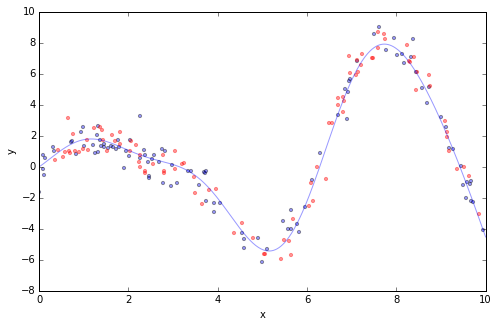

In [10]:
# Gradient Boosting in Practise

# Here we have a regression problem with one feature x and the
# corresponding response y. We draw 100 training data points by
# picking an x coordinate uniformuly at random, evaluating
# the ground truth (sinoid function; light blue line) and 
# then adding some random gaussian noise. In addition to the
# 100 training points (blue) we also draw 100 test data points
# (red) which we will use to evaluate our approximation.

%pylab inline
import numpy as np

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """Generate training and testing data"""
    np.random.seed(13)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    xtrain, ytrain = x[train_mask, np.newaxis], y[train_mask]
    xtest, ytest = x[~train_mask, np.newaxis], y[~train_mask]
    return xtrain, xtest, ytrain, ytest

xtrain, xtest, ytrain, ytest = gen_data(200)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data(figsize=(8, 5)):
    fig = plt.figure(figsize=figsize)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=0.4,
                 label='ground truth')
    #plot training and testing data
    plt.scatter(xtrain, ytrain, s=10, alpha=0.4)
    plt.scatter(xtest, ytest, s=10, alpha=0.4, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
plot_data(figsize=(8, 5))

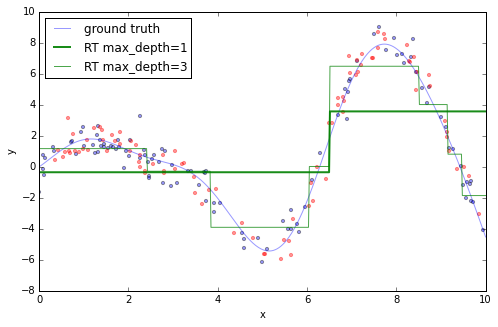

In [11]:
# If you fit an individual regression tree to the above data you 
# get a piece-wise constant approximation. The deeper you
# grow the tree, the more constant segments you can accommodate
# and thus, the more variance you can capture.

from sklearn.tree import DecisionTreeRegressor
plot_data()
est = DecisionTreeRegressor(max_depth=1).fit(xtrain, ytrain)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
        label='RT max_depth=1', color='g', alpha=0.9,
        linewidth=2)
est = DecisionTreeRegressor(max_depth=3).fit(xtrain, ytrain)
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]),
        label='RT max_depth=3', color='g', alpha=0.7,
        linewidth=1)
plt.legend(loc='upper left')

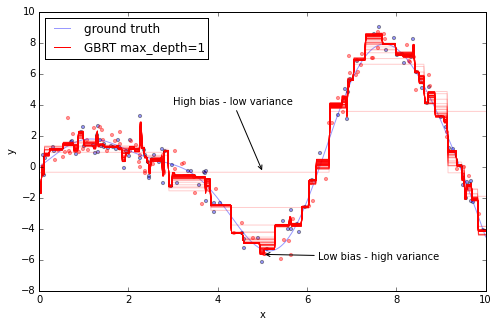

In [12]:
# Now let's fit a gradient boosting model to the training data and
# let's see how the approximation progresses as we add
# more and more trees. The scikit-learn gradient boosting
# estimators allows you to evaluate the prediction of a model as a function 
# of the number of trees via the 
# staged_(predict|predict_proba) methods. These return a 
# generator that iterators over the predictions as you
# add more and more trees.

from itertools import islice

plot_data()

est = GradientBoostingRegressor(n_estimators=1000, max_depth=1,
                               learning_rate=1.0)
est.fit(xtrain, ytrain)

ax = plt.gca()
first = True

# step over prediction as we added 20 more trees.
for pred in islice(est.staged_predict(x_plot[:, np.newaxis]), 0, 1000, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xycoords='data',
                                                    xytext=(3, 4), textcoords='data',
                                                    arrowprops=dict(arrowstyle="->",
                                                                    connectionstyle="arc"))
        first = False
        
pred = est.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xycoords='data', xytext=(6.25, -6),
                                            textcoords='data', arrowprops=dict(arrowstyle="->",
                                                                               connectionstyle="arc"))
plt.legend(loc='upper left')

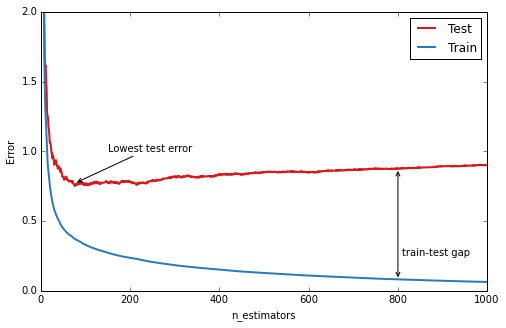

In [13]:
# The above plot shows 50 red lines where each shows the response of the 
# GBRT model after 20 trees have been added. It starts with a very crude
# approximation that can only fit more-or-less constant functions
# (i.e. High Bias - Low Variance) but as we add more trees the more
# variance our model can capture resulting in the solid red line.

# We can see that the more trees we add to our GBRT model and the
# deeper the individual trees are the more variance we can capture
# thus the higher the complexity of our model. But as usual in ML,
# model complexity comes at a price -- overfitting.

# An imoprtant diagnostic when using GBRT in practice is the so-called
# deviance plot that shows the training/testing error (or deviance)
# as a function of the number of trees.

n_estimators = len(est.estimators_)

def deviance_plot(est, xtest, ytest, ax=None, label='', train_color='#2c7bb6',
                 test_color='#d7191c', alpha=1.0):
    """Deviance plot for est, use xtest & ytest for test error"""
    test_dev = np.empty(n_estimators)
    
    for i, pred in enumerate(est.staged_predict(xtest)):
        test_dev[i] = est.loss_(ytest, pred)
        
    if ax is None:
        fig = plt.figure(figsize=(8, 5))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color,
           label='Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,
           label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim((0, 2))
    return test_dev, ax

test_dev, ax = deviance_plot(est, xtest, ytest)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',
            xytext=(150, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, est.train_score_[799]), textcoords='data',
                  arrowprops=dict(arrowstyle="<->"))
ax.text(810, 0.25, 'train-test gap')

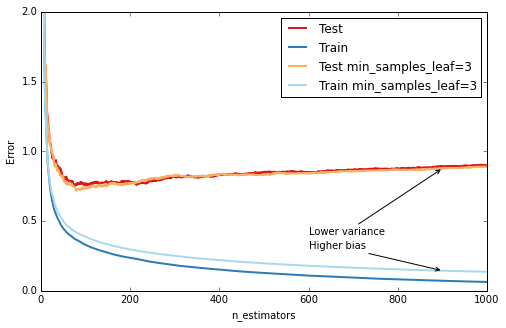

In [14]:
# The blue line shows the training error. It decreases rapidly and
# continues to decrease (but more slowly) as we add more trees. 
# The testing error (red line) also decreases rapidly but soon
# reaches its minimum and then starts increasing. This is an
# example of overfitting the idiosyncracies of the training data
# which in our case is the random Gaussian noise we added.
# A large gap between training and testing data is usually a sign
# of overfitting.

# The great thing about Gradient Boosting is that it provides a number
# of knobs to control overfitting. These are usually subsumed by the
# term regularization.

## Regularization
# GBRT provide three knobs to control overfitting: tree structure,
# shrinkage, and randomization.

# Tree Structure

# The depth of individual trees is one aspect of model complexity. The
# depth of trees basically control the degree of feature interactions
# that your model can fit. For example, if you want to capture the
# interactions between a fature latitude and a feature longitude your
# trees need a depth o at least two. Unfortunately, the degree of 
# feature interactions is not known in advance but is usually fine to 
# assume that is fairly low -- in practice a depth of 4-6 usually
# gives the best results. In skikit-learn you can control the depth
# of trees with max_depth argument.

# ANother way to control the depth of the trees is by enforcing a 
# lower bound on the number of samples in a leaf; this will
# avoid unbalanced splits where a leaf is formed for just one extreme
# data point. In skikit-learn you can so this using the argument 
# min_samples_leaf. This is effectively a means to introduce bias into
# your model with the hope to also reduce variance as shown below.

def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.iteritems())

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(xtrain, ytrain)
    
    test_dev, ax = deviance_plot(est, xtest, ytest, ax=ax, label=fmt_params(params),
                                train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xycoords='data',
            xytext=(600, 0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower variance', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.4), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')



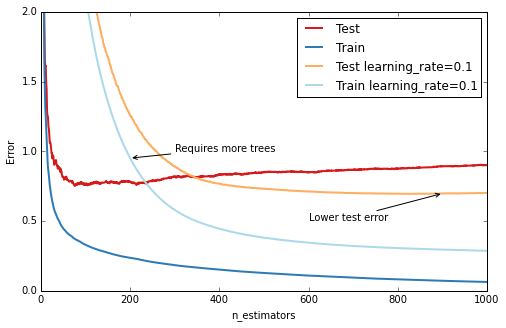

In [15]:
## Shrinkage

# The most important regularization technique for GBRT is shrinkage;
# the idea is basically to do slow learning by shrinking the predictions
# of each individual tree by some small scalar, the learning_rate.
# BY doing so the model has to re-enforce concepts. A lower 
# learning_rate requires a higher number of n_estimators to get to the
# same level of training error -- so it's trading runtime against
# accuracy.

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1,
                                   learning_rate=1.0)
    est.set_params(**params)
    est.fit(xtrain, ytrain)
    
    test_dev, ax = deviance_plot(est, xtest, ytest, ax=ax,
                                label=fmt_params(params),
                                train_color=train_color,
                                test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
            xytext=(300, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

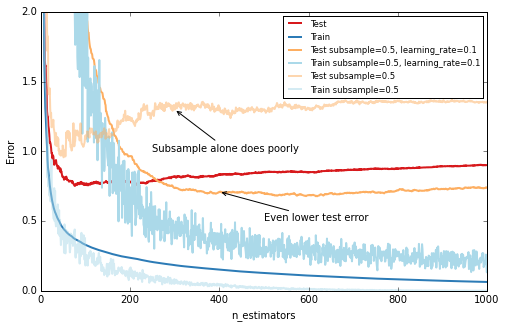

In [18]:
# Stochastic Gradient Descent

# Similar to random forest, introducing randomization into the tree building process
# can lead to higher accuracy. Scikit-learn provides two ways to introduce randomization:
# a) subsampling the training set before growing each tree (subsample)
# b) subsampling the features before finding the best split node
# (max_features). Experience shows that the latter works better if there
# is a sufficiently large number of features (>30). One thing worth
# noting is that both options reduce runtime.

# Below we show the effect of using subsample=0.5, i.e. growing each
# tree on 50% of the training data, on our toy example.

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(xtrain, ytrain)
    test_dev, ax = deviance_plot(est, xtest, ytest, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)

ax.annotate('Even lower test error', xy=(400, test_dev[399]), xycoords='data',
            xytext=(500, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(xtrain, ytrain)
test_dev, ax = deviance_plot(est, xtest, ytest, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), xycoords='data',
            xytext=(250, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right', fontsize='small')

In [20]:
# Hyperparamter Tuning

# We now have introduced a number of hyperparaeters -- as usual
# in machine learning it is quite tedious to optimize them.
# Especially, since they interact with each other (e.g. learing_rate
# and n_estimators or max_depth and max_features).

# We usually follow this recipe to tune the hyperparameters for a 
# Gradient Boosting Model:

# 1. Chose loss based on your problem at hand (i.e. target metric)
# 2. Pick n_estimators as large as computationally possible (e.g. 3000)
# 3. Tune max_depth, learning_rate, min_samples_leaf, and max_features
# via grid search
# 4. Increase n_estimators even more and tunr learning_rate again
# holding other parameters fixed.

# Scikit-learn provides a convenient API for hyperparameter tuning
# and grid search

from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
             'max_depth': [4, 6],
             'min_samples_leaf': [3, 5, 9, 17],
             #'max_features': [1.0, 0.3, 0.1] ## Not possible in our example
             }

est = GradientBoostingRegressor(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(xtrain, ytrain)

# best hyperparamter setting
gs_cv.best_params_


{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 5}

In [21]:
# Use Case: California Housing

# This use-case study shows how to apply GBRT to a real-world dataset.
# The task is to predict the log median house value for census block
# groups in California. The dataset is based on the 1990 census
# comprising roughly 20,000 groups. There are 8 features for each group
# including: median income, avg house age, latitude & longitude.
# To be consistent with EoSL we use Mean Absolute Error as our
# target metric and evaluate results on an 80-20 train-test split.

import pandas as pd
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

xtrain, xtest, ytrain, ytest = train_test_split(cal_housing.data,
                                                np.log(cal_housing.target),
                                                test_size=0.2,
                                                random_state=1)
names = cal_housing.feature_names

downloading Cal. housing from http://lib.stat.cmu.edu/modules.php?op=modload&name=Downloads&file=index&req=getit&lid=83 to /Users/paulsingman/scikit_learn_data


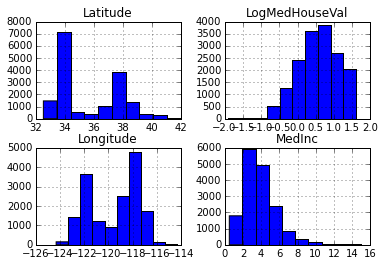

In [22]:
# There are some challenging aspects to this dataset:
# a) heterogeneous features (different scales and distributions)
# b) non-linear feature interactions (specifically latitude and longitude)
# Furthermore the data contains some extreme values of the response
# (log median house value) -- such a dataset strongly benefits from
# robustregression techiniques such as huberized loss functions.

# Below you can see histogramsfor some of the features and the reponse.
# You can see that they are quite different: median income is left 
# skewed, altitude and longitude are bi-model, and log median house
# value is right skewed.

import pandas as pd
x_df = pd.DataFrame(data=xtrain, columns=names)
x_df['LogMedHouseVal'] = ytrain
_ = x_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'LogMedHouseVal'])

In [24]:
# Let's fit a GBRT model to this dataset and inspect the model

est = GradientBoostingRegressor(n_estimators=3000, max_depth=6, learning_rate=0.04,
                            loss='huber', random_state=0)
est.fit(xtrain, ytrain)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.04,
             loss='huber', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             random_state=0, subsample=1.0, verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(ytest, est.predict(xtest))
print('MAE: %.4f' % mae)

MAE: 0.1449


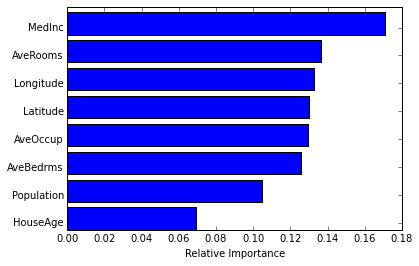

In [26]:
## Feature Importance

# OFten features do not contribute equally to predict the target response.
# When interpreting a mode, the first question usually is:
# what are those important features and how do they contribute in 
# predicting the response?
# A GBRT model derives this information from the fitted regression trees 
# which intrinsically perform feature selection by choosing appropriate
# split points. You can access this information via the instance
# attribute est.feature_importances_.

# sort importances
indices = np.argsort(est.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), est.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative Importance')

/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


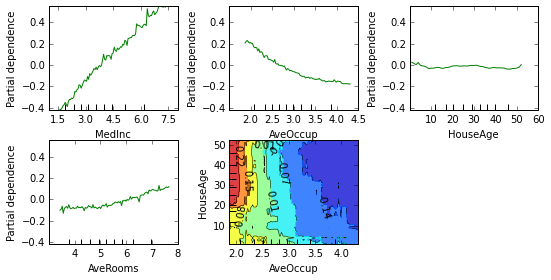

In [28]:
# Partial Dependence

# Partial Dependence plots show the dependence between the reponse and a set
# of features, marginalizing over the values of all other features.
# Intuitively we can interpret the partial dependence as the expected response
# as a function of the features we conditioned on.

# The plot below contains 4 one-way partial dependence plots (PDP) each
# showing the effect of an individual feature on the response.
# We can see that median Income (MedInc) has a linear relationship
# with the log median house value. The contour plot shows a two-way PDP.
# Here we can see an interesting feature interaction. It seems that 
# house age by itself has hardly any effect on the response but when
# Ave0ccup is small it has an effect (the older the house the
# the higher the price)

from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms',
           ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(est, xtrain, features, feature_names=names,
                                  figsize=(8, 6))